In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
from math import *

In [3]:
class BlackScholes:
    
        
    def ft_bs_pricing(self, Option_type,S,K,T,r,rf,sigma):
        
        global d1
        global d2
        d1 = (log(S / K) + (r - rf + sigma ** 2 / 2) * T) / (sigma * sqrt(T)) 
        d2 = d1 - sigma* sqrt(T) 
        
        if Option_type == "Call":
            option_price = S* exp(-rf*T)* norm.cdf(d1) - K * exp(-r*T)*norm.cdf(d2)
            return option_price
        elif Option_type == "Put":
            option_price = K* exp(-r*T)* norm.cdf(-d2) - S * exp(-rf*T)*norm.cdf(-d1)
            return option_price
        else:
            return "incorrect parameters"
       
   
    def ft_delta(self, Option_type,S,K,T,r,rf,sigma):
        if Option_type == "Call":
            delta = exp(-rf*T) * norm.cdf(d1)   
        elif Option_type == "Put":
            delta = exp(-rf*T) * (norm.cdf(d1)-1)
        return delta
    
    
    def ft_gamma(self, Option_type,S,K,T,r,rf,sigma):
        return (norm.pdf(d1)*exp(-rf*T) )/ ( S*sigma*sqrt(T) )
    
    def ft_vega(self, Option_type,S,K,T,r,rf,sigma):
        return S*sqrt(T)*norm.pdf(d1)*exp(-rf*T)
    
    def ft_theta(self, Option_type,S,K,T,r,rf,sigma):
        a = (-S *norm.pdf(d1) *sigma* exp(-rf*T)) /(2*sqrt(T))
        b = rf * S * norm.cdf(d1) * exp(-rf*T) 
        c = r * K * exp(-r*T)* norm.cdf(d2)
        b2 = rf * S * norm.cdf(-d1) * exp(-rf*T) 
        c2 = r * K * exp(-r*T)* norm.cdf(-d2)
        if Option_type == "Call":
             theta = a+b-c   
        elif Option_type == "Put":
            theta = a-b2+c2 
        return theta
    
    def ft_rho_dom(self, Option_type,S,K,T,r,rf,sigma):
        if Option_type == "Call":
            rho_dom = K * T *exp(-r*T) * norm.pdf(d2)   
        elif Option_type == "Put":
            rho_dom = -K * T *exp(-r*T) * norm.pdf(-d2)  
        return rho_dom
    
    def ft_rho_fgn(self, Option_type,S,K,T,r,rf,sigma):
        if Option_type == "Call":
            rho_fgn = -S * T *exp(-rf*T) * norm.pdf(d1)   
        elif Option_type == "Put":
            rho_fgn = S * T *exp(-rf*T) * norm.pdf(-d1)  
        return rho_fgn
    
    def ft_vanna(self, Option_type,S,K,T,r,rf,sigma):
        return -exp(-rf*T) * norm.cdf(d1) * d2 / sigma 
    
    
    def __init__(self,Option_type,S,K,T,r,rf,sigma):
        
        self.option_type = Option_type
        self.asset_price = S
        self.strike = K
        self.time_to_exp = T
        self.d_rate = r
        self.f_rate = rf
        self.asset_volatility = sigma
        
        self.price = self.ft_bs_pricing(Option_type,S,K,T,r,rf,sigma)
        
        
        self.delta = self.ft_delta(Option_type,S,K,T,r,rf,sigma)
        self.gamma = self.ft_gamma(Option_type,S,K,T,r,rf,sigma)
        self.theta = self.ft_theta(Option_type,S,K,T,r,rf,sigma)
        self.vega = self.ft_vega(Option_type,S,K,T,r,rf,sigma)
        self.rho_dom = self.ft_rho_dom(Option_type,S,K,T,r,rf,sigma)
        self.rho_fgn = self.ft_rho_fgn(Option_type,S,K,T,r,rf,sigma)
        self.vanna = self.ft_vanna(Option_type,S,K,T,r,rf,sigma)
       

In [4]:
# test de la fonction
bs = BlackScholes("Call",20,20,3,0.025,0.02,0.2)
print( bs.price )
print( bs.delta )
print( bs.gamma )
print( bs.vega )
print( bs.theta )

2.713352299002869
0.5515947480770352
0.05297280879637965
12.713474111131115
-0.411108137703669


## Risked based method

In [5]:
## Sans effet des taux

In [6]:
bs = BlackScholes("Call",100,100,1,0.04,0.08,0.30)

price1 = bs.price
delta1 = bs.delta 
gamma1 = bs.gamma 
vega1 = bs.vega
theta1 = bs.theta
rho_dom1 = bs.rho_dom
rho_fgn1 = bs.rho_fgn

bs2 = BlackScholes("Call",140,100,0.9,0.04,0.08,0.32) 
price2 = bs2.price

var_spot = 40
var_vol = 0.02
var_time = -0.1
var_rho_dom = 0.02
var_rho_fgn = -0.02

# taylor series approx : f(x) = f(x0) + f'(x0)(x-x0) + f''(x0)(x-x0)**2 +... 
PnL_spot =  delta1*var_spot + 0.5*gamma1*var_spot**2 + (1/6)*(bs2.gamma -bs.gamma)*var_spot**2 
PnL_vol = vega1*var_vol
PnL_time = -theta1*var_time
PnL_dom = rho_dom1*var_rho_dom 
PnL_fgn = rho_dom1*var_rho_fgn
PnL = PnL_spot  + PnL_time + PnL_vol #+ PnL_dom + PnL_fgn

Real_PnL = price2 - price1
print("Total PnL",PnL)
print("Observed PnL",Real_PnL)
print(end = '\n')

print("Impact of price change", round(PnL_spot/Real_PnL*100,2),"%")
print("Impact of time", round(PnL_time/Real_PnL*100,2),"%")
print("Impact of volatility", round(PnL_vol/Real_PnL*100,2),"%")
#print("Impact of domestic rate", round(PnL_dom/Real_PnL*100,2),"%")
#print("Impact of foreign rate", round(PnL_fgn/Real_PnL*100,2),"%")
print("Unexplained PnL",round( (Real_PnL - PnL) /Real_PnL*100,2),"%") 


Total PnL 26.8769633173624
Observed PnL 27.23367821175605

Impact of price change 97.19 %
Impact of time -1.2 %
Impact of volatility 2.7 %
Unexplained PnL 1.31 %


In [7]:
## Avec effet des taux

In [8]:
bs = BlackScholes("Call",100,100,1,0.04,0.08,0.30)

price1 = bs.price
delta1 = bs.delta 
gamma1 = bs.gamma 
vega1 = bs.vega
theta1 = bs.theta
rho_dom1 = bs.rho_dom
rho_fgn1 = bs.rho_fgn

bs2 = BlackScholes("Call",140,100,0.9,0.06,0.06,0.32) 
price2 = bs2.price

var_spot = 40
var_vol = 0.02
var_time = -0.1
var_rho_dom = 0.02
var_rho_fgn = -0.02

# taylor series approx : f(x) = f(x0) + f'(x0)(x-x0) + f''(x0)(x-x0)**2 +... 
PnL_spot =  delta1*var_spot + 0.5*gamma1*var_spot**2 + (1/6)*(bs2.gamma -bs.gamma)*var_spot**2 
PnL_vol = vega1*var_vol
PnL_time = -theta1*var_time
PnL_dom = rho_dom1*var_rho_dom 
PnL_fgn = rho_dom1*var_rho_fgn
PnL = PnL_spot  + PnL_time + PnL_vol + PnL_dom + PnL_fgn

Real_PnL = price2 - price1
print("Total PnL",PnL)
print("Observed PnL",Real_PnL)
print(end = '\n')

print("Impact of price change", round(PnL_spot/Real_PnL*100,2),"%")
print("Impact of time", round(PnL_time/Real_PnL*100,2),"%")
print("Impact of volatility", round(PnL_vol/Real_PnL*100,2),"%")
print("Impact of domestic rate", round(PnL_dom/Real_PnL*100,2),"%")
print("Impact of foreign rate", round(PnL_fgn/Real_PnL*100,2),"%")
print("Unexplained PnL",round( (Real_PnL - PnL) /Real_PnL*100,2),"%") 


Total PnL 26.734948924715265
Observed PnL 30.73023269480405

Impact of price change 85.67 %
Impact of time -1.07 %
Impact of volatility 2.4 %
Impact of domestic rate 2.4 %
Impact of foreign rate -2.4 %
Unexplained PnL 13.0 %


### PnL spot
On sait que :
$ V(S_1) = V(S_0) + \frac{dV}{dS} * (S_1-S_0) + \frac{1}{2!}\frac{d^2V}{dS^2} * (S_1-S_0)^2 + \frac{1}{3!} \frac{d^3V}{dS^3} * (S_1-S_0)^3 + $... 
Avec $\frac{dV}{dS} = \Delta$ de l'option, $\frac{d^2V}{dS^2} = \gamma$ de l'option.

Comme on ne connait pas $\frac{d^3V}{dS^3}$, on  peut l'estimer par les différentielles : 

$\frac{d^3V}{dS^3} = \frac{d}{dS}\left(\frac{d^2V}{dS^2}\right) = \frac{d}{dS}\left(\gamma\right) =~ \frac{\Delta \gamma}{\Delta S}$

Ainsi on peut ecrire:

$ V(S_1) = V(S_0) + \Delta * (S_1-S_0) + \frac{1}{2!}\gamma * (S_1-S_0)^2 + \frac{1}{3!}\frac{\gamma_1 - \gamma_0}{S_1-S_0} * (S_1-S_0)^3 + $... 

D'où :

$ V(S_1) = V(S_0) + \Delta * (S_1-S_0) + \frac{1}{2}\gamma * (S_1-S_0)^2 + \frac{1}{6}(\gamma_1 - \gamma_0) * (S_1-S_0)^2 + $... 


## Step re-evaluation

In [9]:
## Sans effet des taux

In [10]:
price1 = BlackScholes("Call",100,100,1,0.04,0.08,0.30).price 
price2 = BlackScholes("Call",140,100,0.9,0.04,0.08,0.32).price  
Real_PnL = price2-price1

price3 = BlackScholes("Call",140,100,1,0.04,0.08,0.30).price 
PnL_spot = price3-price1

price4 = BlackScholes("Call",100,100,0.9,0.04,0.08,0.30).price 
PnL_time = price4-price1

price5 = BlackScholes("Call",100,100,1,0.04,0.08,0.32).price 
PnL_vol = price5-price1


PnL = PnL_spot + PnL_time + PnL_vol 
print("Total PnL",PnL)
print("Observed PnL",Real_PnL)
print(end = '\n')

print("Impact of price change", round(PnL_spot/Real_PnL*100,2),"%")
print("Impact of time", round(PnL_time/Real_PnL*100,2),"%")
print("Impact of volatility", round(PnL_vol/Real_PnL*100,2),"%")
print("Impact of domestic rate", round(PnL_dom/Real_PnL*100,2),"%")
print("Impact of foreign rate", round(PnL_fgn/Real_PnL*100,2),"%")
print("Unexplained PnL",round( (Real_PnL - PnL) /Real_PnL*100,2),"%") 



Total PnL 26.9305802081551
Observed PnL 27.23367821175605

Impact of price change 97.45 %
Impact of time -1.26 %
Impact of volatility 2.7 %
Impact of domestic rate 2.7 %
Impact of foreign rate -2.7 %
Unexplained PnL 1.11 %


In [11]:
## Avec efffet des taux

In [12]:
price1 = BlackScholes("Call",100,100,1,0.04,0.08,0.30).price 
price2 = BlackScholes("Call",140,100,0.9,0.06,0.06,0.32).price  
Real_PnL = price2-price1

price3 = BlackScholes("Call",140,100,1,0.04,0.08,0.30).price 
PnL_spot = price3-price1

price4 = BlackScholes("Call",100,100,0.9,0.04,0.08,0.30).price 
PnL_time = price4-price1

price5 = BlackScholes("Call",100,100,1,0.04,0.08,0.32).price 
PnL_vol = price5-price1

price6 = BlackScholes("Call",100,100,1,0.06,0.08,0.30).price 
PnL_dom = price6-price1

price7 = BlackScholes("Call",100,100,1,0.04,0.06,0.30).price 
PnL_fgn = price7-price1

PnL = PnL_spot + PnL_time + PnL_vol + PnL_dom + PnL_fgn
print("Total PnL",PnL)
print("Observed PnL",Real_PnL)
print(end = '\n')

print("Impact of price change", round(PnL_spot/Real_PnL*100,2),"%")
print("Impact of time", round(PnL_time/Real_PnL*100,2),"%")
print("Impact of volatility", round(PnL_vol/Real_PnL*100,2),"%")
print("Impact of domestic rate", round(PnL_dom/Real_PnL*100,2),"%")
print("Impact of foreign rate", round(PnL_fgn/Real_PnL*100,2),"%")
print("Unexplained PnL",round( (Real_PnL - PnL) /Real_PnL*100,2),"%") 



Total PnL 28.663657246276976
Observed PnL 30.73023269480405

Impact of price change 86.36 %
Impact of time -1.12 %
Impact of volatility 2.4 %
Impact of domestic rate 2.48 %
Impact of foreign rate 3.16 %
Unexplained PnL 6.72 %


In [31]:
## simulation du MBG
# Le probleme de cette simulation...c'est qu on doit supposer
# 3 choses constantes durant toute la periode(1an): volatlite,taux domestique et taux etranger

In [28]:
def geo_paths(S0, r, rf, sigma, T, N, n):
    dt = float(T) / N
    paths = np.zeros((N + 1, n), np.float64)
    paths[0] = S0
    for t in range(1, N + 1):
        Rand = np.random.standard_normal(n)
        paths[t] = paths[t - 1] * np.exp((r -rf - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * Rand)
    return paths

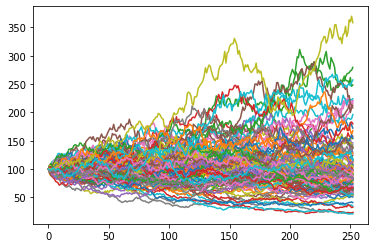

In [29]:
S0 = 100
r = 0.05
rf = 0.03
sigma = 0.50
T = 1
N = 252
n = 100


np.random.seed(123)
paths = geo_paths(S0, r,rf, sigma, T, N, n)
plt.plot(paths)

In [30]:
data = pd.DataFrame(paths)
data

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,96.598129,103.148216,100.853251,95.326677,98.153180,105.295310,92.602886,98.617038,104.024533,97.266415,...,103.646035,96.046810,100.529940,103.736360,98.909142,103.257986,96.601362,95.756470,101.160009,98.771646
2,98.530439,96.878021,103.098420,103.413127,98.036221,105.364692,93.089269,92.961056,105.386280,92.431834,...,104.182686,95.916221,101.121743,103.282059,99.483372,93.227733,95.745557,95.382971,100.036800,98.055070
3,100.695493,95.030458,110.452217,105.635507,97.975915,104.637466,92.797255,90.281677,105.026972,93.207900,...,100.672968,97.915851,104.168980,100.424358,93.595518,95.253696,101.530549,96.599788,100.502050,100.577907
4,103.108449,92.542694,108.137657,107.643676,97.491873,109.022489,90.723434,92.403037,106.122343,92.798772,...,103.488583,101.520627,103.802437,99.705096,88.472988,93.999711,100.560693,97.308720,99.928659,101.311718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,70.359882,94.022045,142.757058,163.874738,153.469298,74.010807,217.817278,23.483319,147.553844,119.373113,...,149.759496,98.397493,72.539220,64.007983,99.971076,147.619744,80.591422,87.057388,341.483463,127.796186
249,67.477751,92.303329,144.771464,158.377764,151.593674,72.711727,222.339821,22.742711,146.967146,115.497505,...,149.634820,98.805704,74.527334,66.322556,105.087585,142.987766,86.279012,85.294907,363.231436,127.865828
250,65.395077,92.535824,145.492537,156.969543,151.100150,72.488036,222.775170,21.760908,147.315829,121.993408,...,155.251824,101.014579,75.763694,64.252688,100.963305,140.147403,88.953634,87.048382,359.770995,131.852505
251,68.142545,90.417084,142.033414,155.517262,146.105774,68.062005,215.632855,22.349507,144.736210,123.401193,...,160.252808,93.806137,79.165378,68.080779,98.244341,139.560207,94.037371,84.812020,369.616622,121.762765
